In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, load_model
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.data import SAT_CLASSES_ACCURACY
from hmpai.pytorch.normalization import *
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.behaviour.sat2 import SAT2_SPLITS
from hmpai.visualization import predict_with_auc, set_seaborn_style, plot_peak_timing
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from pymer4.models import Lmer
from scipy.stats import pearsonr
DATA_PATH = Path(os.getenv("DATA_PATH"))

labels_t1 = ["negative", "t1_1", "t1_2", "t1_3"]
labels_t2 = ["negative", "t2_1", "t2_2", "t2_3"]
labels = ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]
orders = [(0, 1, 2, 3, 4, 5), (0, 1, 3, 2, 4, 5), (0, 3, 1, 2, 4, 5), (0, 1, 3, 4, 2, 5), (0, 3, 1, 4, 2, 5), (0, 3, 4, 1, 2, 5)]
# orders = [(0, 1, 2, 3, 4, 5), (0, 1, 2, 3, 4, 5), (0, 1, 2, 4, 3, 5), (0, 1, 3, 2, 4, 5), (0, 1, 3, 4, 2, 5), (3, 0, 1, 2, 4, 5)]
# orders = [(0, 1, 2, 3, 4, 5), (0, 1, 2, 4, 3, 5), (0, 1, 3, 2, 4, 5), (0, 1, 3, 4, 2, 5)]

### Combined tasks

In [2]:
def determine_order(paths: list[Path], labels: list[list[str]]):
    df_t1 = pd.read_csv(paths[0])
    df_t2 = pd.read_csv(paths[1])
    # Combine dataframes on 'epoch' and 'participant'
    df = df_t1.merge(
        df_t2, on=["condition", "epoch", "participant"], suffixes=("_t1", "_t2")
    )
    labels_t1 = labels[0]
    labels_t2 = labels[1]
    pred_cols_t1 = [labels_t1[i] + "_pred" for i in range(1, len(labels_t1))]
    pred_cols_t2 = [labels_t2[i] + "_pred" for i in range(1, len(labels_t2))]

    # Add ISI to task 2 predictions to get absolute time
    df[pred_cols_t2] = df[pred_cols_t2].add(df["interval_t1"] * 250, axis=0)

    peak_order = df[pred_cols_t1 + pred_cols_t2].apply(lambda x: x.argsort(), axis=1)
    for i, col in enumerate(pred_cols_t1 + pred_cols_t2):
        df[f"event_{i}_idx"] = peak_order.iloc[:, i]

    return df


def determine_order_cmb(path: Path, labels: list[str]):
    df = pd.read_csv(path)
    # df.loc[df["condition"] == "short", ["t2_1_pred", "t2_2_pred", "t2_3_pred"]] = (
    #     df.loc[
    #         df["condition"] == "short", ["t2_1_pred", "t2_2_pred", "t2_3_pred"]
    #     ].subtract(62, axis=0)
    # )
    pred_cols = [labels[i] + "_pred" for i in range(1, len(labels))]

    peak_order = df[pred_cols].apply(lambda x: x.argsort(), axis=1)
    for i, col in enumerate(pred_cols):
        df[f"event_{i}_idx"] = peak_order.iloc[:, i]

    return df


def remove_invalid_orders(df: pd.DataFrame, labels: list[list[str]]):
    # Remove order and condition combinations that occur less than 50 times
    order_columns = [
        f"event_{i}_idx" for i in range(len(labels[0]) + len(labels[1]) - 2)
    ]
    df["order"] = df[order_columns].apply(tuple, axis=1)
    order_condition_counts = df.groupby(["order", "condition"]).size()
    valid_combinations = order_condition_counts[order_condition_counts >= 50].index
    df = df[df.set_index(["order", "condition"]).index.isin(valid_combinations)]

    order_mapping = {order: idx for idx, order in enumerate(orders)}
    df["order_idx"] = df["order"].map(order_mapping)
    return df

In [28]:
path = Path("files/cmb_peaks.csv")

df = determine_order_cmb(path, labels_t1 + labels_t2[1:])
df = remove_invalid_orders(df, [labels_t1, labels_t2])

/tmp/ipykernel_3264898/3133857679.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["order_idx"] = df["order"].map(order_mapping)


In [3]:
paths = [Path("files/t1_peaks.csv"), Path("files/t2_peaks.csv")]
df = determine_order(paths, [labels_t1, labels_t2])
df = remove_invalid_orders(df, [labels_t1, labels_t2])

/tmp/ipykernel_3461459/3133857679.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["order_idx"] = df["order"].map(order_mapping)


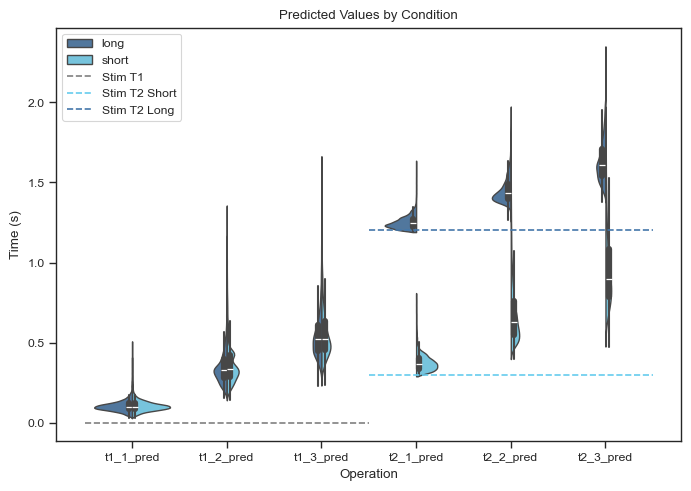

In [8]:
set_seaborn_style()
df_long = df.melt(
    id_vars="condition",
    value_vars=["t1_1_pred", "t1_2_pred", "t1_3_pred", "t2_1_pred", "t2_2_pred", "t2_3_pred"],
    var_name="prediction_type",
    value_name="predicted_value"
)

plt.figure(figsize=(7, 5))
df_long["predicted_value"] = df_long["predicted_value"] / 250
sns.violinplot(
    data=df_long,
    x="prediction_type",
    y="predicted_value",
    hue="condition",
    split=True,  # Optional: shows side-by-side violins in one
    cut=0,
)

plt.xlabel("Operation")
plt.ylabel("Time (s)")
plt.title("Predicted Values by Condition")
plt.tight_layout()
plt.hlines(0, -0.5, 2.5, colors="gray", linestyles='dashed', label='Stim T1')
plt.hlines(0.3, 2.5, 5.5, colors=sns.color_palette()[1], linestyles='dashed', label='Stim T2 Short')
plt.hlines(1.2, 2.5, 5.5, colors=sns.color_palette()[0], linestyles='dashed', label='Stim T2 Long')
plt.legend()
plt.show()

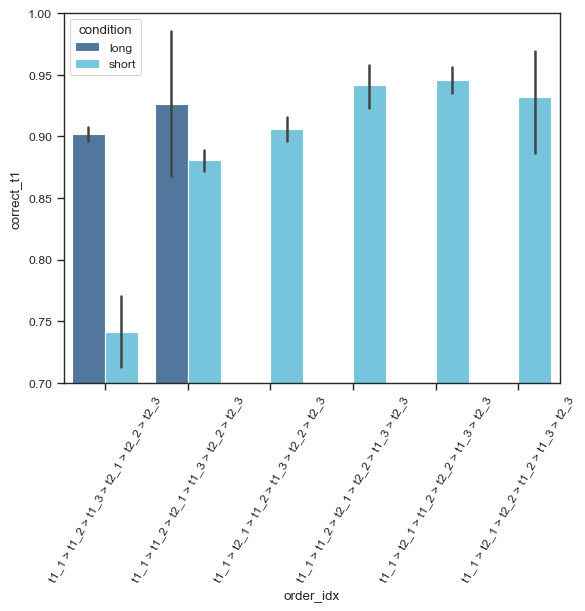

In [10]:
# Correct
from statannotations.Annotator import Annotator
from itertools import combinations
set_seaborn_style()
ax = sns.barplot(data=df, x="order_idx", y="correct_t1", hue="condition")
xticks = [' > '.join([labels[i] for i in order]) for order in orders]
plt.xticks(range(len(orders)), xticks, rotation=60)
plt.ylim(0.7, 1)

plt.show()

In [ ]:
def performance_order_regression(df, task: str = "t1"):
    correct_col = f"correct_{task}"
    df = df.copy()
    df = df[df["condition"] == "short"]
    df = df[["participant", "order_idx", correct_col]]
    df = df.dropna()
    df["participant"] = df["participant"].astype("category")
    df["order_idx"] = pd.Categorical(df["order_idx"], ordered=True)

    formula = f"{correct_col} ~ order_idx + (1|participant)"
    model = Lmer(formula, data=df, family="binomial")

    model.fit(verbose=False, factors={"order_idx": ["0", "1", "2", "3", "4", "5"]})

    print(model.summary())
    return model


model_perf = performance_order_regression(df, task="t1")

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: correct_t1~order_idx+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 11741	 Groups: {'participant': 21.0}

Log-likelihood: -3855.501 	 AIC: 7725.002

Random effects:

                    Name   Var    Std
participant  (Intercept)  0.38  0.616

No random effect correlations specified

Fixed effects:

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: correct_t1~order_idx+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 11741	 Groups: {'participant': 21.0}

Log-likelihood: -3855.501 	 AIC: 7725.002

Random effects:

                    Name   Var    Std
participant  (Intercept)  0.38  0.616

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     1.303   0.991    1.614  0.159  3.679      2.695       5.021   
order_idx1      0.895   0.719    1.072

/opt/conda/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [ ]:
# Post-hoc multiple comparisons, compare all order_idxs with each other
contrasts = model_perf.post_hoc("order_idx", p_adjust="holm")
print(contrasts)

P-values adjusted by holm method for 15 comparisons
(  order_idx  Estimate  2.5_ci  97.5_ci     SE   DF
1         0     1.303   0.991    1.614  0.159  inf
2         1     2.198   1.917    2.478  0.143  inf
3         2     2.321   2.025    2.616  0.151  inf
4         3     2.922   2.499    3.345  0.216  inf
5         4     2.900   2.554    3.245  0.176  inf
6         5     2.324   1.579    3.069  0.380  inf,                    Contrast  Estimate  2.5_ci  97.5_ci     SE   DF  Z-stat  \
1   order_idx0 - order_idx1    -0.895  -1.160   -0.631  0.090  inf  -9.953   
2   order_idx0 - order_idx2    -1.018  -1.327   -0.709  0.105  inf  -9.669   
3   order_idx0 - order_idx3    -1.619  -2.165   -1.073  0.186  inf  -8.698   
4   order_idx0 - order_idx4    -1.597  -2.012   -1.183  0.141  inf -11.310   
5   order_idx0 - order_idx5    -1.021  -2.097    0.055  0.367  inf  -2.786   
6   order_idx1 - order_idx2    -0.123  -0.357    0.112  0.080  inf  -1.537   
7   order_idx1 - order_idx3    -0.724  -1.2

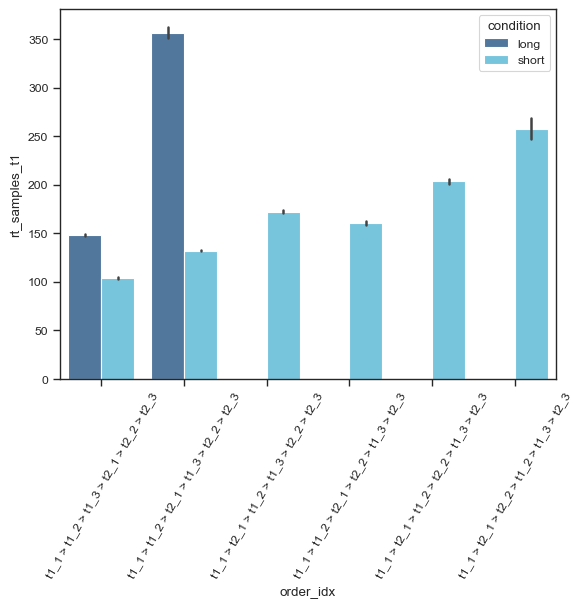

In [25]:
# RT
from statannotations.Annotator import Annotator
from itertools import combinations
set_seaborn_style()
ax = sns.barplot(data=df, x="order_idx", y="rt_samples_t1", hue="condition")
xticks = [' > '.join([labels[i] for i in order]) for order in orders]
plt.xticks(range(len(orders)), xticks, rotation=60)
# plt.ylim(0.7, 1)

plt.show()

In [48]:
def rt_order_regression(df):
    df = df.copy()
    df = df[df["condition"] == "short"]
    df = df[["participant", "rt_samples_t1", "order_idx"]]
    df["participant"] = df["participant"].astype("category")
    df["order_idx"] = df["order_idx"].astype(str).astype("category")

    formula = "rt_samples_t1 ~ order_idx + (1|participant)"
    model = Lmer(formula, data=df)

    model.fit(verbose=False, factors={"order_idx": ["0", "1", "2", "3", "4", "5"]})

    print(model.summary())
    return model
model_rt = rt_order_regression(df)

Linear mixed model fit by REML [’lmerMod’]
Formula: rt_samples_t1~order_idx+(1|participant)

Family: gaussian	 Inference: parametric

Number of observations: 11797	 Groups: {'participant': 21.0}

Log-likelihood: -57848.967 	 AIC: 115713.934

Random effects:

                    Name       Var     Std
participant  (Intercept)   320.456  17.901
Residual                  1056.020  32.496

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: rt_samples_t1~order_idx+(1|participant)

Family: gaussian	 Inference: parametric

Number of observations: 11797	 Groups: {'participant': 21.0}

Log-likelihood: -57848.967 	 AIC: 115713.934

Random effects:

                    Name       Var     Std
participant  (Intercept)   320.456  17.901
Residual                  1056.020  32.496

No random effect correlations specified

Fixed effects:

             Estimate   2.5_ci  97.5_ci     SE         DF  T-stat  P-val  Sig
(Intercept)   108.091  100.130

/opt/conda/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [49]:
# Post-hoc multiple comparisons, compare all order_idxs with each other
contrasts = model_rt.post_hoc(
    "order_idx", p_adjust="holm"
)
print(contrasts)

P-values adjusted by holm method for 15 comparisons
(  order_idx  Estimate   2.5_ci  97.5_ci     SE      DF
1         0   108.091   99.688  116.494  4.062  22.991
2         1   137.035  128.837  145.233  3.933  20.199
3         2   167.891  159.657  176.125  3.956  20.678
4         3   167.246  158.767  175.725  4.109  24.068
5         4   201.675  193.379  209.972  3.995  21.519
6         5   249.748  239.941  259.555  4.877  47.731,                    Contrast  Estimate   2.5_ci  97.5_ci     SE         DF  \
1   order_idx0 - order_idx1   -28.944  -32.427  -25.461  1.186  11774.277   
2   order_idx0 - order_idx2   -59.800  -63.578  -56.022  1.287  11780.072   
3   order_idx0 - order_idx3   -59.155  -64.121  -54.189  1.692  11776.135   
4   order_idx0 - order_idx4   -93.584  -97.745  -89.423  1.417  11782.736   
5   order_idx0 - order_idx5  -141.657 -150.866 -132.447  3.137  11780.019   
6   order_idx1 - order_idx2   -30.856  -33.151  -28.561  0.782  11784.108   
7   order_idx1 - order

In [ ]:
# IRI
set_seaborn_style()
df['IRI'] = ((df["rt_samples_t2"] + df["interval_t1"] * 250) - df["rt_samples_t1"]) / 250 * 1000
# df['IRI'] = df["t2_3_pred"] - df["t1_3_pred"]
sns.barplot(data=df, x="order_idx", y="IRI", hue="condition")
xticks = [' > '.join([labels[i] for i in order]) for order in orders]
plt.xticks(range(len(orders)), xticks, rotation=60)
plt.show()

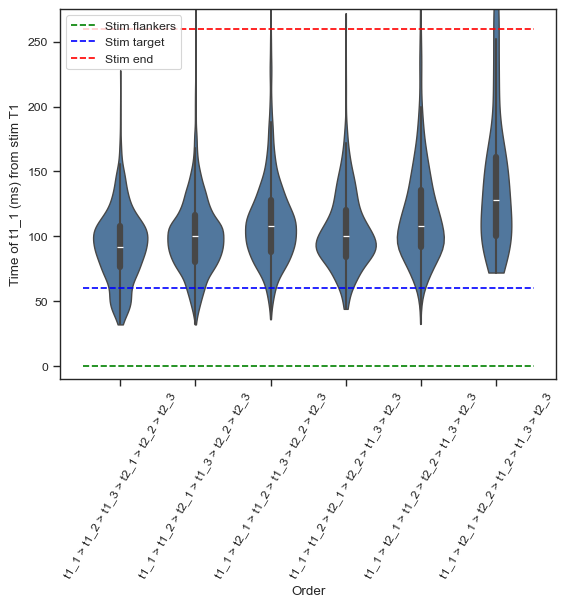

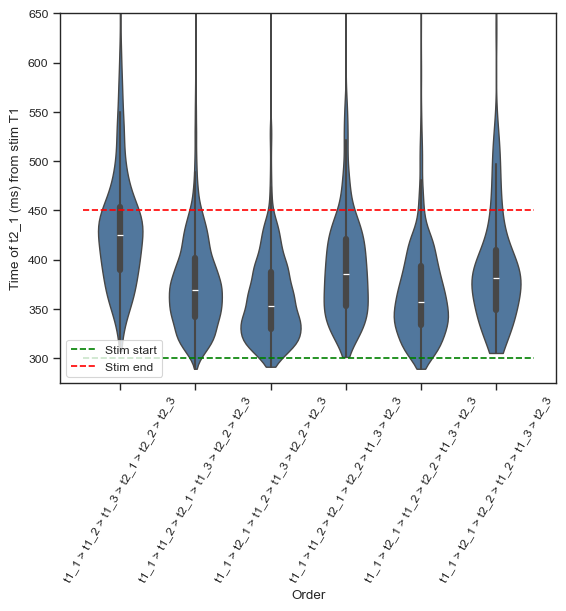

In [34]:
def plot_t1_encoding(df):
    event = "t1_1"
    set_seaborn_style()
    df = df.copy()
    df = df[df["condition"] == "short"]
    ev_col = f"{event}_pred"
    df[ev_col] = df[ev_col] / 250 * 1000
    sns.violinplot(data=df, x="order_idx", y=ev_col, cut=0)
    xticks = [' > '.join([labels[i] for i in order]) for order in orders]
    plt.xticks(range(len(orders)), xticks, rotation=60)
    plt.ylabel(f"Time of {event} (ms) from stim T1")
    plt.xlabel("Order")
    plt.ylim(-10, 275)
    # Stimulus presentation is from 300 > 450 ms
    plt.hlines(0, xmin=-0.5, xmax=len(orders)-0.5, color="green", linestyle="--", label="Stim flankers")
    plt.hlines(60, xmin=-0.5, xmax=len(orders)-0.5, color="blue", linestyle="--", label="Stim target")
    plt.hlines(260, xmin=-0.5, xmax=len(orders)-0.5, color="red", linestyle="--", label="Stim end")
    plt.legend()
    plt.show()


def plot_t2_encoding(df):
    event = "t2_1"
    set_seaborn_style()
    df = df.copy()
    df = df[df["condition"] == "short"]
    ev_col = f"{event}_pred"
    df[ev_col] = df[ev_col] / 250 * 1000
    sns.violinplot(data=df, x="order_idx", y=ev_col, cut=0)
    xticks = [' > '.join([labels[i] for i in order]) for order in orders]
    plt.xticks(range(len(orders)), xticks, rotation=60)
    plt.ylabel(f"Time of {event} (ms) from stim T1")
    plt.xlabel("Order")
    plt.ylim(275, 650)
    # Stimulus presentation is from 300 > 450 ms
    plt.hlines(300, xmin=-0.5, xmax=len(orders)-0.5, color="green", linestyle="--", label="Stim start")
    plt.hlines(450, xmin=-0.5, xmax=len(orders)-0.5, color="red", linestyle="--", label="Stim end")
    plt.legend()
    plt.show()


plot_t1_encoding(df)
plot_t2_encoding(df)

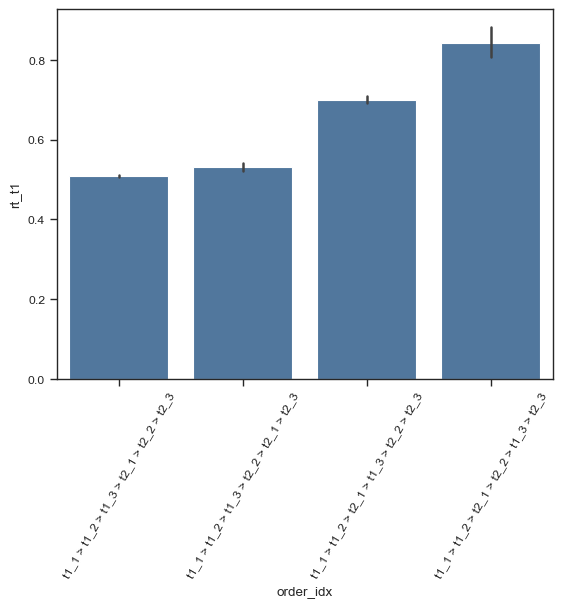

In [49]:
set_seaborn_style()
sns.barplot(data=df[df['condition'] == 'short'], x="order_idx", y="rt_t1")
xticks = [' > '.join([labels[i] for i in order]) for order in orders]
plt.xticks(range(len(orders)), xticks, rotation=60)
plt.show()

In [56]:
def plot_timing_effect_on_rt(df, event_idx, task="t1"):
    threshold = 50
    event_idx = f"event_{event_idx}_idx"

    event_counts = df.groupby(["condition", event_idx]).size().reset_index(name="count")
    valid_pairs = event_counts[event_counts["count"] > threshold]
    df = df.merge(
        valid_pairs[["condition", event_idx]],
        on=["condition", event_idx],
        how="inner",  # Keep only rows that match valid (condition, event) pairs
    )
    df[f"rt_samples_{task}"] = (df[f"rt_samples_{task}"] / 250) * 1000
    sns.violinplot(data=df, x=event_idx, y=f"rt_samples_{task}", hue="condition")
    plt.xlabel(f"Event at position {event_idx} in time")
    plt.ylabel(f"RT {task} (ms)")
    plt.show()


def plot_order_effect_on_rt(df, orders: list[list[int]], labels=["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]):
    set_seaborn_style()
    event_cols = [col for col in df.columns if col.startswith("event_")]
    df = df.copy()
    df["order_idx"] = -1  # Initialize with -1 for rows that don't match any order
    df = df[df["condition"] == "short"]
    for idx, order in enumerate(orders):
        # Compare order of events with order in dataframe
        mask = (
            (df[event_cols[0]] == order[0])
            & (df[event_cols[1]] == order[1])
            & (df[event_cols[2]] == order[2])
            & (df[event_cols[3]] == order[3])
            & (df[event_cols[4]] == order[4])
            & (df[event_cols[5]] == order[5])
        )
        df.loc[mask, "order_idx"] = idx
    # Filter out rows with order_idx -1
    df = df[df["order_idx"] != -1]
    # df["rt_t1"] = (df["rt_t1"] / 250) * 1000
    df["rt_t1"] = df["rt_t1"] * 1000
    ax = sns.violinplot(data=df, x="order_idx", y="rt_t1", cut=0)
    xticks = [' > '.join([labels[i] for i in order]) for order in orders]
    plt.xticks(range(len(orders)), xticks, rotation=45)
    plt.hlines(y=610.63, xmin=-0.5, xmax=len(orders)-0.5, color=sns.color_palette()[2], linestyles='dashed', label="Mean RT (short)")
    plt.hlines(y=599.84, xmin=-0.5, xmax=len(orders)-0.5, color=sns.color_palette()[1], linestyles='dashed', label="Mean RT (long)")
    plt.legend()
    plt.xlabel("Order of events")
    plt.ylabel("RT t1 (ms)")
    plt.ylim(200, 1200)
    plt.show()

In [ ]:
plot_order_effect_on_rt(df, [[0, 1, 2, 3, 4, 5], [0, 1, 3, 2, 4, 5], [0, 3, 1, 2, 4, 5], [0, 1, 3, 4, 2, 5], [0, 3, 1, 4, 2, 5], [0, 3, 4, 1, 2, 5]])


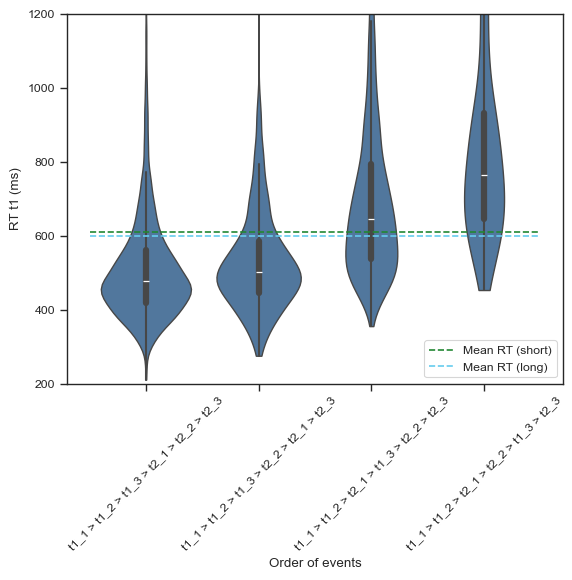

In [57]:
plot_order_effect_on_rt(df, orders)

<Axes: xlabel='t1_3_pred', ylabel='rt_samples_t1'>

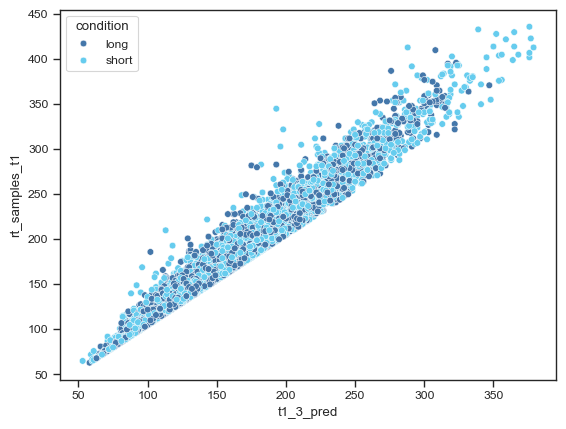

In [73]:
sns.scatterplot(data=df, x= "t1_3_pred", y="rt_samples_t1", hue="condition")

In [ ]:
df[df["event_3_idx"] == 4].iloc[0,:]
# t1_1 - 43, t2_1, 112, t1_2 - 150, t2_2 - 161, t1_3 - 191, t2_3 - 235
# THE event_n_idx N-TH EVENT is the INDEX IN LABELS

condition                                                       short
epoch                                                           481.0
participant                                                       VP5
rt_samples_t1                                                     196
t1_1_pred                                                        43.0
t1_1_true                                                        13.0
t1_1_peak_values    [0.8136295676231384, 0.18116751313209534, -0.1...
t1_2_pred                                                       150.0
t1_2_true                                                       158.0
t1_2_peak_values    [-2.080155372619629, -2.2829220294952393, -1.4...
t1_3_pred                                                       191.0
t1_3_true                                                       190.0
t1_3_peak_values    [-0.8969032764434814, -0.6788650155067444, -1....
rt_samples_t2                                                     180
t2_1_pred           

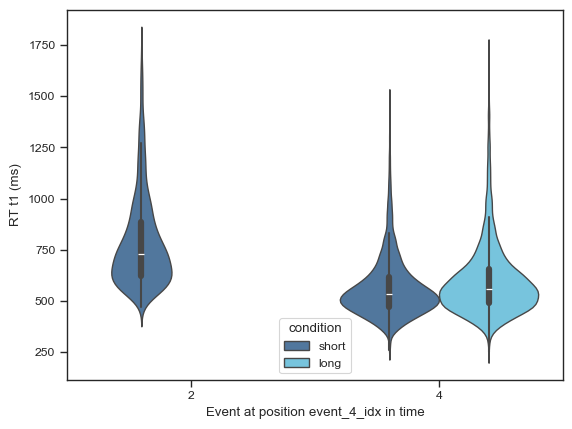

In [124]:
plot_timing_effect_on_rt(df, 4, task='t1')

In [6]:
def plot_order_distribution_stacked(df, labels, min_count=50):
    set_seaborn_style()
    # Count the occurrences of each order, grouped by condition
    df = df[["condition", "order"]]
    order_counts = df.groupby(["condition", "order"]).value_counts().reset_index(name="Count")
    print(order_counts)

    # Create a DataFrame for plotting
    order_df = pd.DataFrame(order_counts)
    order_df.columns = ["condition", "order", "Count"]

    # Convert the Order tuples to strings for better readability
    order_df["order"] = order_df["order"].apply(lambda x: " > ".join([labels[i] for i in x]))

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Count", y="order", hue="condition", data=order_df)
    plt.xlabel("Count")
    plt.ylabel("Order")
    plt.xlim(0, order_df["Count"].max() + 50)
    plt.show()

  condition               order  Count
0      long  (0, 1, 2, 3, 4, 5)  10925
1      long  (0, 1, 3, 2, 4, 5)     68
2     short  (0, 1, 2, 3, 4, 5)    889
3     short  (0, 1, 3, 2, 4, 5)   5647
4     short  (0, 1, 3, 4, 2, 5)    675
5     short  (0, 3, 1, 2, 4, 5)   2843
6     short  (0, 3, 1, 4, 2, 5)   1611
7     short  (0, 3, 4, 1, 2, 5)    132


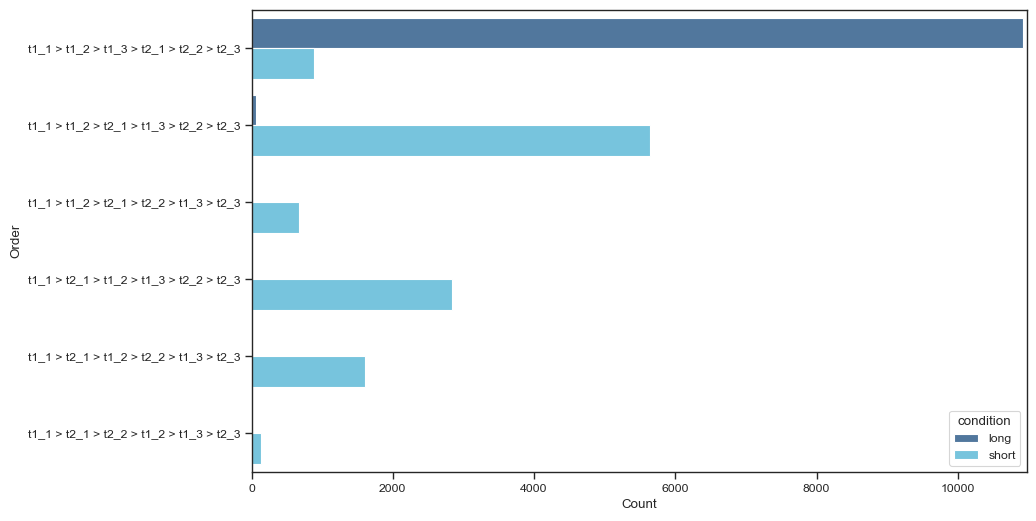

In [7]:
plot_order_distribution_stacked(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"], min_count=50)


  condition               order  Count
0      long  (0, 1, 2, 3, 4, 5)  10837
1     short  (0, 1, 2, 3, 4, 5)   7960
2     short  (0, 1, 2, 4, 3, 5)    612
3     short  (0, 1, 3, 2, 4, 5)   2705
4     short  (0, 1, 3, 4, 2, 5)    189


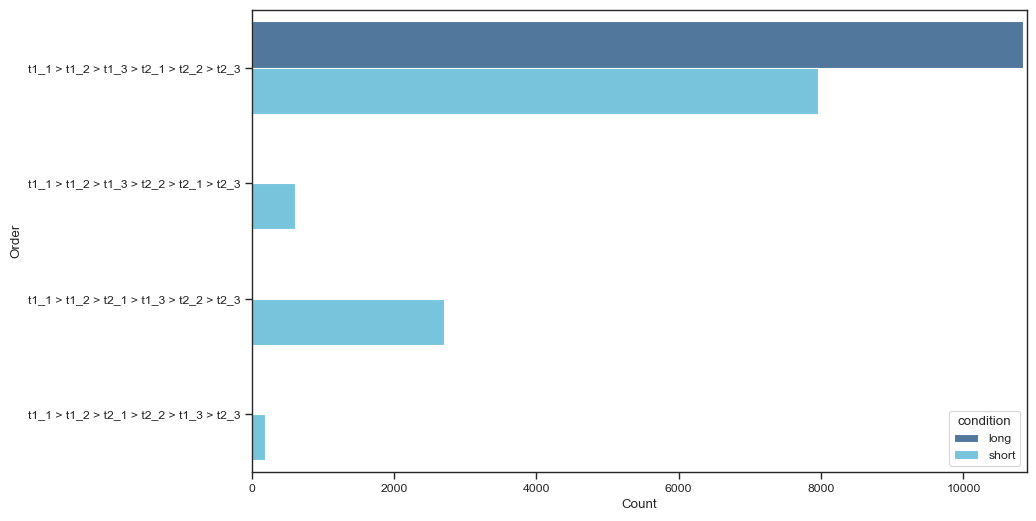

In [19]:
plot_order_distribution_stacked(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"], min_count=50)


  condition               order  Count
0      long  (0, 1, 2, 3, 4, 5)  10912
1     short  (0, 1, 2, 3, 4, 5)   5471
2     short  (0, 1, 2, 4, 3, 5)     54
3     short  (0, 1, 3, 2, 4, 5)   5865
4     short  (0, 1, 3, 4, 2, 5)    248
5     short  (3, 0, 1, 2, 4, 5)     51


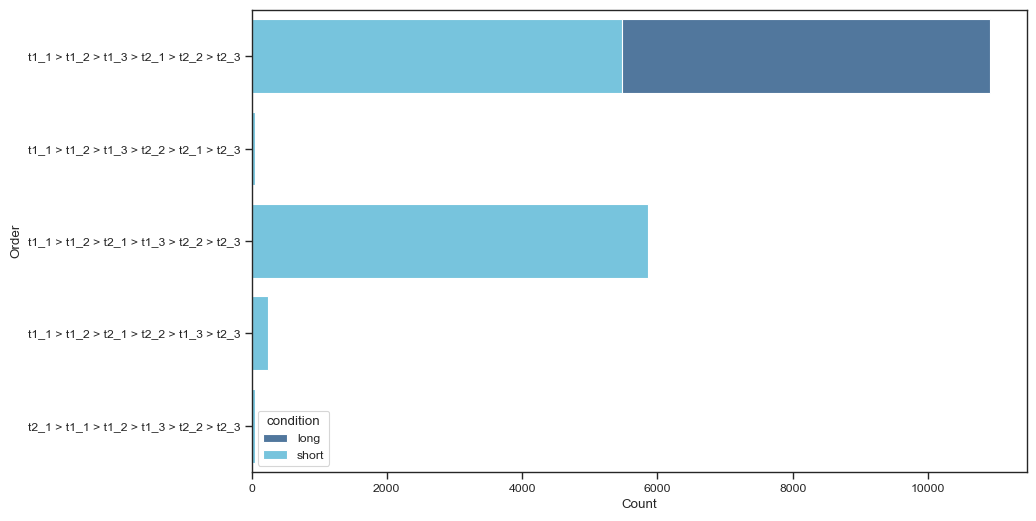

In [88]:
plot_order_distribution_stacked(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"], min_count=50)


  condition               order  Count
0      long  (0, 1, 2, 3, 4, 5)  10964
1     short  (0, 1, 2, 3, 4, 5)   1531
2     short  (0, 1, 3, 2, 4, 5)   5887
3     short  (0, 1, 3, 4, 2, 5)    881
4     short  (0, 3, 1, 2, 4, 5)   2061
5     short  (0, 3, 1, 4, 2, 5)   1286
6     short  (0, 3, 4, 1, 2, 5)    103


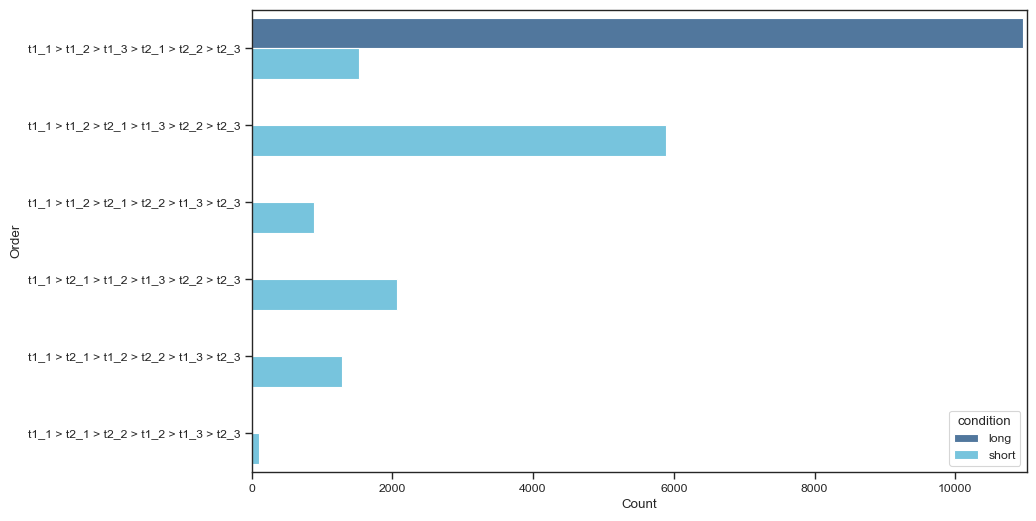

In [21]:
plot_order_distribution_stacked(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"], min_count=50)

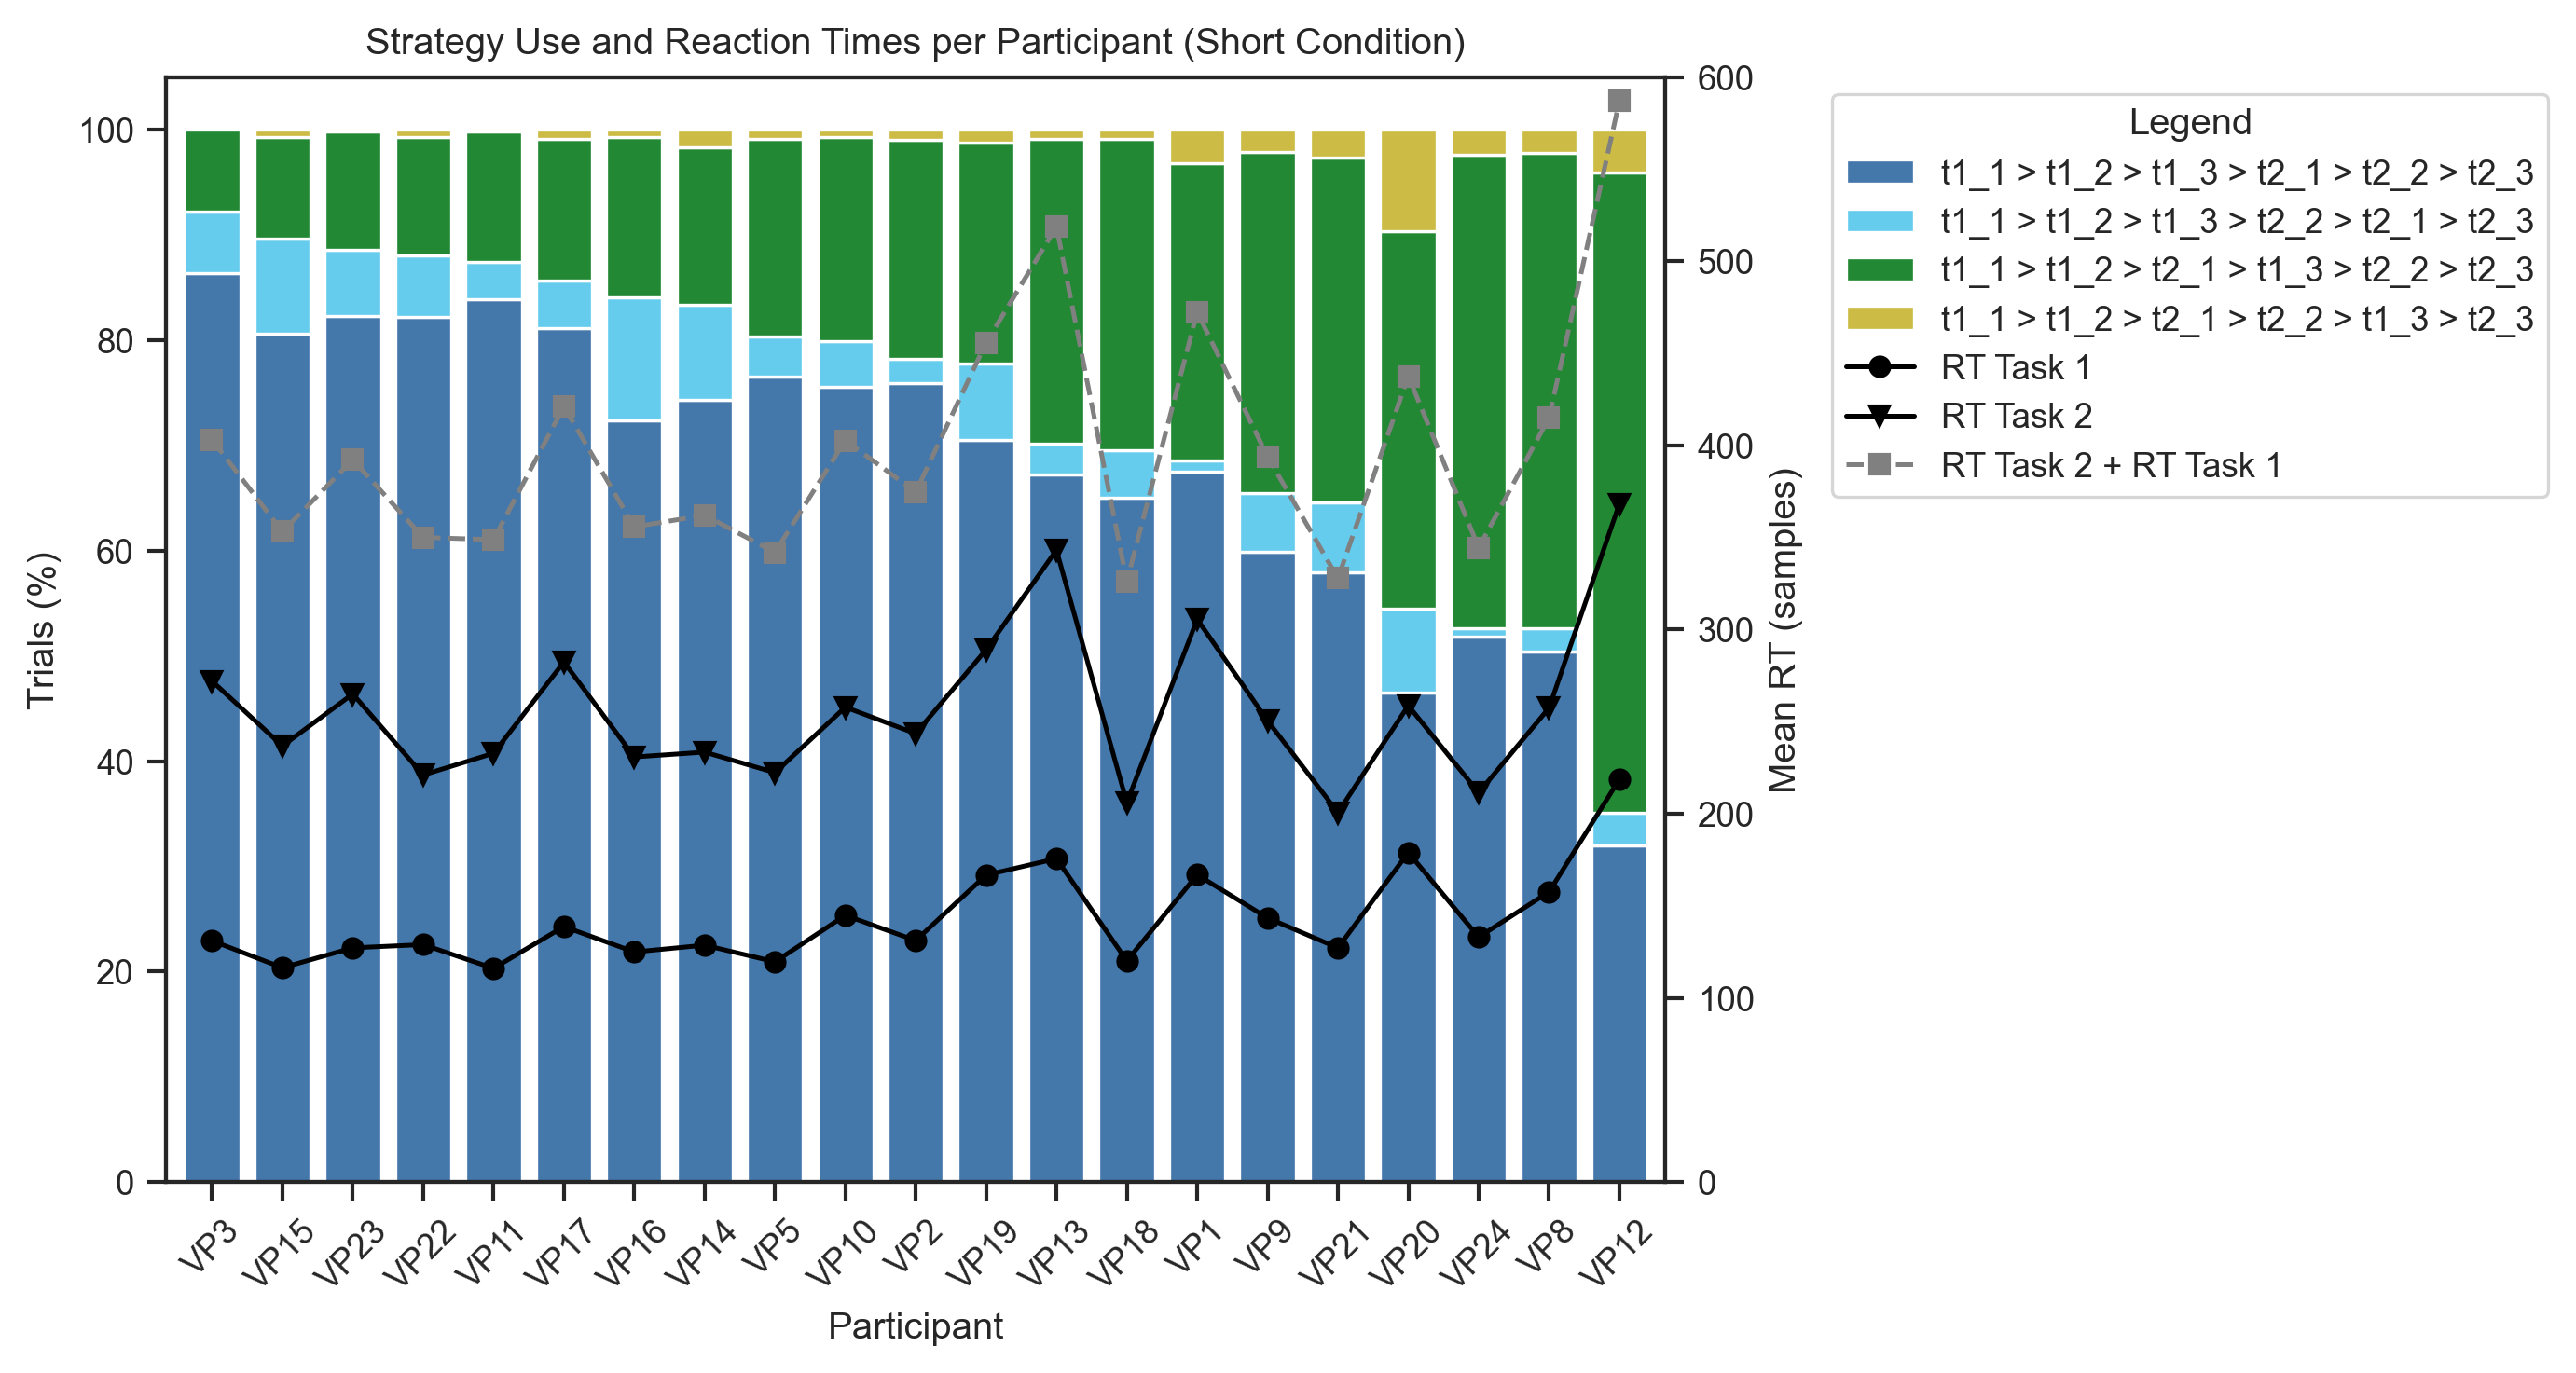

In [67]:
def plot_relative_order_with_rt_lines(df, labels):
    set_seaborn_style()

    if "participant" not in df.columns:
        raise ValueError("The DataFrame must contain a 'participant' column.")

    # Filter for short condition
    df_short = df[df["condition"] == "short"].copy()

    # === STRATEGY DISTRIBUTION ===
    order_counts = df_short.groupby(["participant", "order"]).size().reset_index(name="Count")

    order_counts["order"] = order_counts["order"].apply(lambda x: " > ".join([labels[i] for i in x]))

    pivot_df = order_counts.pivot_table(index="participant", columns="order", values="Count", fill_value=0)
    percent_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

    # Sort participants by usage of the first strategy
    first_two_strategies = percent_df.columns[:2]
    percent_df["sort_key"] = percent_df[first_two_strategies].sum(axis=1)
    percent_df = percent_df.sort_values(by="sort_key", ascending=False).drop(columns="sort_key")
    sorted_participants = percent_df.index.tolist()

    # === MEAN RTs ===
    df_short["rt_samples_t1"] = df_short["rt_t1"] * 250
    df_short["rt_samples_t2"] = df_short["rt_samples"]
    rt_df = df_short.groupby("participant")[["rt_samples_t1", "rt_samples_t2"]].mean()
    rt_df = rt_df.loc[sorted_participants]

    # === PLOTTING ===
    fig, ax1 = plt.subplots(figsize=(9.5, 5), dpi=300)

    # Stacked bar plot
    percent_df.plot(kind="bar", stacked=True, ax=ax1, width=0.8)
    ax1.set_ylabel("Trials (%)")
    ax1.set_xlabel("Participant")
    ax1.set_title("Strategy Use and Reaction Times per Participant (Short Condition)")
    ax1.legend(title="Order", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Line plot on twin y-axis
    ax2 = ax1.twinx()
    ax2.plot(range(len(rt_df)), rt_df["rt_samples_t1"], marker="o", linestyle="-", color="black", label="RT Task 1")
    ax2.plot(range(len(rt_df)), rt_df["rt_samples_t2"], marker="v", linestyle="-", color="black", label="RT Task 2")
    ax2.plot(range(len(rt_df)), rt_df["rt_samples_t2"] + rt_df["rt_samples_t1"], marker="s", linestyle="--", color="gray", label="RT Task 2 + RT Task 1")
    ax2.set_ylabel("Mean RT (samples)")
    ax2.set_ylim(0, 600)

    # x-axis tick labels
    ax1.set_xticks(range(len(sorted_participants)))
    ax1.set_xticklabels(sorted_participants, rotation=45)

    # Combine legends
    bars_legend = ax1.get_legend_handles_labels()
    lines_legend = ax2.get_legend_handles_labels()
    ax1.legend(
        handles=bars_legend[0] + lines_legend[0],
        labels=bars_legend[1] + lines_legend[1],
        bbox_to_anchor=(1.10, 1),
        loc="upper left",
        title="Legend"
    )

    plt.tight_layout()
    plt.show()
plot_relative_order_with_rt_lines(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"])

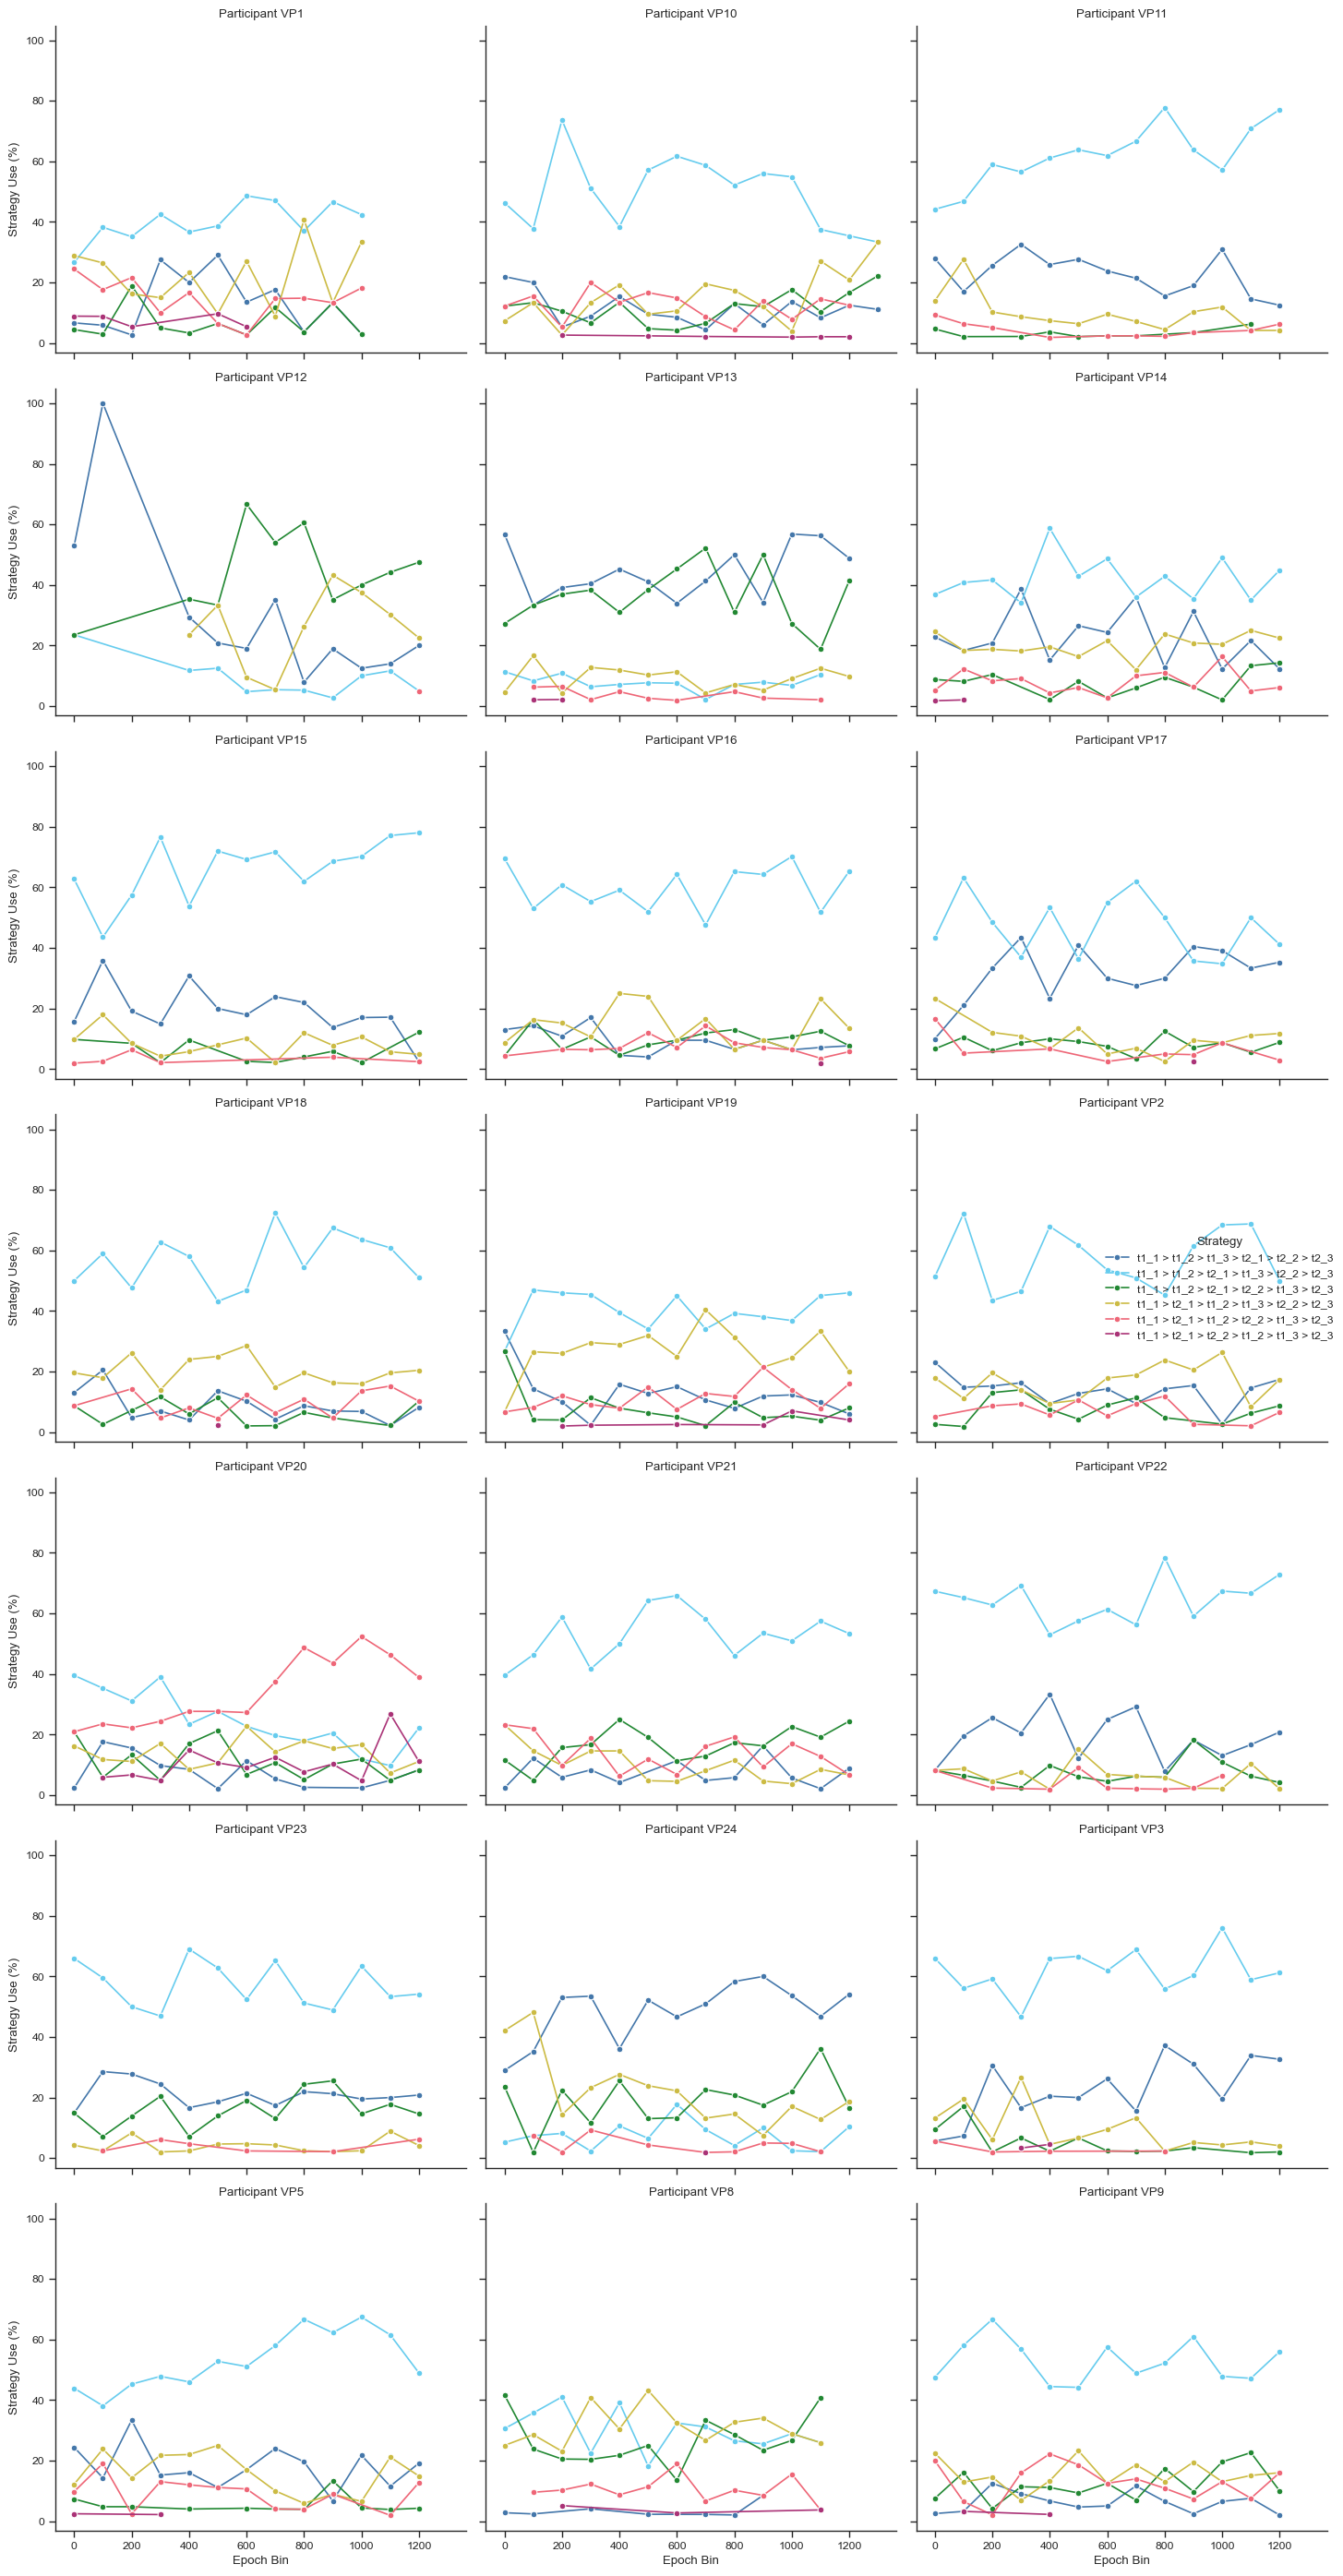

In [15]:
def plot_strategy_lines_facetgrid(df, labels, bin_size=20):
    # Ensure required columns
    if not {"participant", "epoch", "order", "condition"}.issubset(df.columns):
        raise ValueError("The DataFrame must contain 'participant', 'epoch', 'order', and 'condition' columns.")

    # Filter for short condition
    df_short = df[df["condition"] == "short"].copy()

    # Add readable order label and epoch bins
    df_short["order_label"] = df_short["order"].apply(lambda x: " > ".join([labels[i] for i in x]))
    df_short["epoch_bin"] = (df_short["epoch"] // bin_size) * bin_size

    # Calculate counts and percentages
    counts = (
        df_short.groupby(["participant", "epoch_bin", "order_label"])
        .size()
        .reset_index(name="count")
    )
    counts["total"] = counts.groupby(["participant", "epoch_bin"])["count"].transform("sum")
    counts["percent"] = 100 * counts["count"] / counts["total"]

    # Plot with FacetGrid
    g = sns.FacetGrid(
        counts,
        col="participant",
        col_wrap=3,
        height=4,
        sharey=True
    )
    g.map_dataframe(sns.lineplot, x="epoch_bin", y="percent", hue="order_label", marker="o")

    # Final tweaks
    g.set_axis_labels("Epoch Bin", "Strategy Use (%)")
    g.set_titles("Participant {col_name}")
    g.add_legend(title="Strategy")
    plt.tight_layout()
    plt.show()

plot_strategy_lines_facetgrid(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"], bin_size=100)

In [ ]:
def correlate_strategy_with_rt(df, labels):
    # Filter for "short" condition
    df_short = df[df["condition"] == "short"].copy()

    # Count strategies per participant
    order_counts = df_short.groupby(["participant", "order"]).size().reset_index(name="Count")

    # Convert order tuples to readable strings
    order_counts["order"] = order_counts["order"].apply(lambda x: " > ".join([labels[i] for i in x]))

    # Pivot to get percent per strategy per participant
    pivot_df = order_counts.pivot_table(index="participant", columns="order", values="Count", fill_value=0)
    percent_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

    rt_df = df_short.groupby("participant")[["rt_samples_t1", "rt_samples_t2"]].mean()
    rt_df["rt_total"] = rt_df["rt_samples_t1"] + rt_df["rt_samples_t2"]

    # Join RTs to strategy percentages
    analysis_df = percent_df.join(rt_df)
    
    # Compute correlations
    correlation_results = []

    for strategy in percent_df.columns:
        rt1_corr, rt1_p = pearsonr(analysis_df[strategy], analysis_df["rt_samples_t1"])
        rt2_corr, rt2_p = pearsonr(analysis_df[strategy], analysis_df["rt_samples_t2"]) 
        rt_total_corr, rt_total_p = pearsonr(analysis_df[strategy], analysis_df["rt_total"])
        correlation_results.append({
            "Strategy": strategy,
            "RT_t1_r": rt1_corr,
            "RT_t1_p": rt1_p,
            "RT_t2_r": rt2_corr,
            "RT_t2_p": rt2_p,
            "RT_cmb_r": rt_total_corr,
            "RT_cmb_p": rt_total_p
        })

    # Format result as DataFrame
    corr_df = pd.DataFrame(correlation_results)

    return corr_df
correlate_strategy_with_rt(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"])

,Strategy,RT_t1_r,RT_t1_p,RT_t2_r,RT_t2_p,RT_cmb_r,RT_cmb_p
0,t1_1 > t1_2 > t1_3 > t2_1 > t2_2 > t2_3,-0.544417,1.072206e-02,-0.191156,0.406515,-0.337692,0.134361
1,t1_1 > t1_2 > t2_1 > t1_3 > t2_2 > t2_3,-0.855146,7.869276e-07,-0.569269,0.007071,-0.704555,0.000363
2,t1_1 > t1_2 > t2_1 > t2_2 > t1_3 > t2_3,0.252339,2.697959e-01,-0.099881,0.666638,0.034520,0.881910
3,t1_1 > t2_1 > t1_2 > t1_3 > t2_2 > t2_3,0.787490,2.265128e-05,0.718751,0.000242,0.774723,0.000037
4,t1_1 > t2_1 > t1_2 > t2_2 > t1_3 > t2_3,0.651467,1.378018e-03,0.207647,0.366424,0.390438,0.080139
5,t1_1 > t2_1 > t2_2 > t1_2 > t1_3 > t2_3,0.456325,3.759246e-02,0.169680,0.462146,0.289170,0.203596


In [9]:
def get_inter_event_timings(
    df: pd.DataFrame,
    event_1: str,
    event_2: str,
    event_disruptor: str = None,
    labels: list[str] = ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"],
    condition: str = None,
    return_df: bool = False,
    source_strategy: int = None,
):
    # Calculate the time difference between two events
    if condition is not None:
        df = df[df["condition"] == condition]
    ev1_label = f"{event_1}_pred"
    ev2_label = f"{event_2}_pred"
    order = orders[source_strategy]

    # If sequence event_1 > event_disruptor > event_2 is not in order, give error
    if event_disruptor is not None:
        if not (
            order.index(labels.index(event_1))
            == order.index(labels.index(event_disruptor)) - 1
            == order.index(labels.index(event_2)) - 2
        ):
            raise ValueError(
                f"Event sequence {event_1} > {event_disruptor} > {event_2} is not in the order {order}"
            )
    elif (
        not order.index(labels.index(event_1)) == order.index(labels.index(event_2)) - 1
    ):
        raise ValueError(
            f"Event sequence {event_1} > {event_2} is not in the order {order}"
        )
    df = df[df["order_idx"] == source_strategy]

    if return_df:
        return df
    else:
        diffs = df[ev2_label] - df[ev1_label]
        df = df[["condition", "epoch", "participant"]]
        df["difference"] = (diffs / 250) * 1000  # Convert to milliseconds
        df["disrupted"] = 1 if event_disruptor is not None else 0
        return df

<Axes: xlabel='sequence', ylabel='difference'>

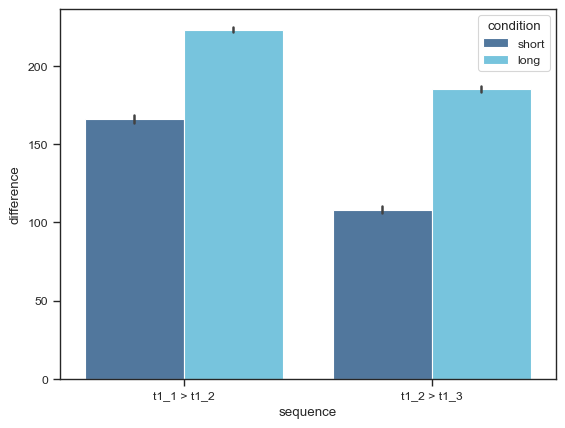

In [ ]:
results = []
for subsequence in [["t1_1", "t1_2"], ["t1_2", "t1_3"]]:
    timings = get_inter_event_timings(df, subsequence[0], subsequence[1], condition='short', source_strategy=0)
    timings["sequence"] = " > ".join(subsequence)
    timings_long = get_inter_event_timings(df, subsequence[0], subsequence[1], condition='long', source_strategy=0)
    timings_long["sequence"] = " > ".join(subsequence)
    results.append(timings)
    results.append(timings_long)
results = pd.concat(results)
results
set_seaborn_style()
sns.barplot(data=results, x="sequence", y="difference", hue="condition")

In [35]:
df['t1_1_pred'].describe()

count    22686.000000
mean        32.490743
std          9.451130
min          9.000000
25%         26.000000
50%         30.000000
75%         36.000000
max        113.000000
Name: t1_1_pred, dtype: float64

In [47]:
df_long

,order_idx,event,pred
0,1,t1_1_pred,28.0
1,0,t1_1_pred,26.0
2,1,t1_1_pred,21.0
3,0,t1_1_pred,48.0
4,0,t1_1_pred,28.0
...,...,...,...
68053,1,t1_3_pred,151.0
68054,2,t1_3_pred,115.0
68055,0,t1_3_pred,138.0
68056,4,t1_3_pred,223.0


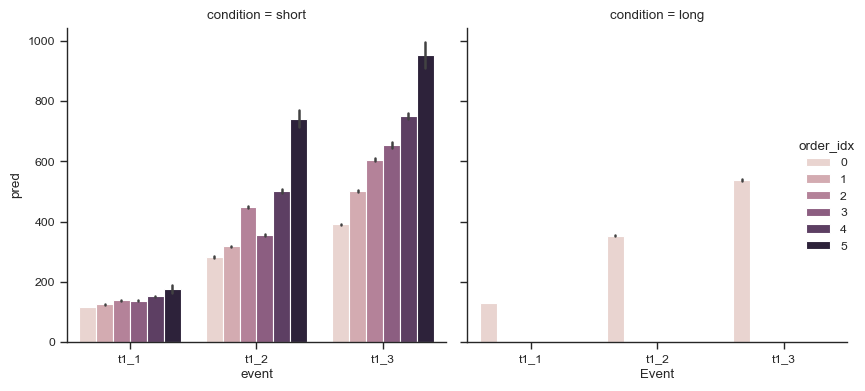

In [ ]:
# Convert to long-form and plot using sns barplot
df_long = df.melt(id_vars=["order_idx", "condition"], value_vars=["t1_1_pred", "t1_2_pred", "t1_3_pred"], var_name="event", value_name="pred")
# df_long = df_long[df_long['condition'] == 'short']
df_long['pred'] = df_long['pred'] / 250 * 1000
# Plot with facets by condition
set_seaborn_style()
sns.catplot(
    data=df_long,
    x="event",
    y="pred",
    hue="order_idx",
    col="condition",       # split plots by condition
    kind="bar",
    height=4,
    aspect=1
)
sns.barplot()
plt.ylabel("Predicted Time (ms)")
plt.xlabel("Event")
plt.xticks([0, 1, 2], ["t1_1", "t1_2", "t1_3"])
plt.tight_layout()
plt.show()

<Axes: xlabel='event', ylabel='pred'>

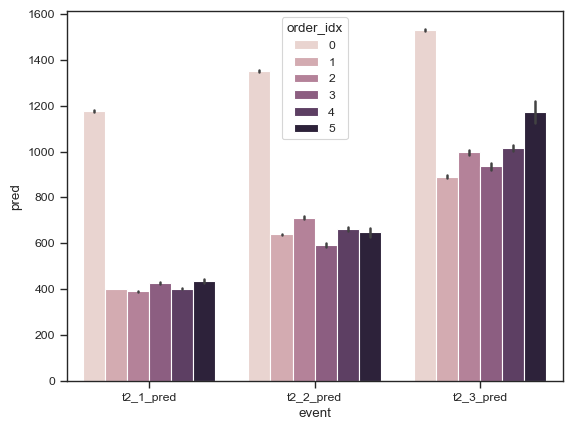

In [52]:
# Convert to long-form and plot using sns barplot
df_long = df.melt(id_vars=["order_idx"], value_vars=["t2_1_pred", "t2_2_pred", "t2_3_pred"], var_name="event", value_name="pred")
df_long['pred'] = df_long['pred'] / 250 * 1000
sns.barplot(data=df_long, x="event", y="pred", hue="order_idx")

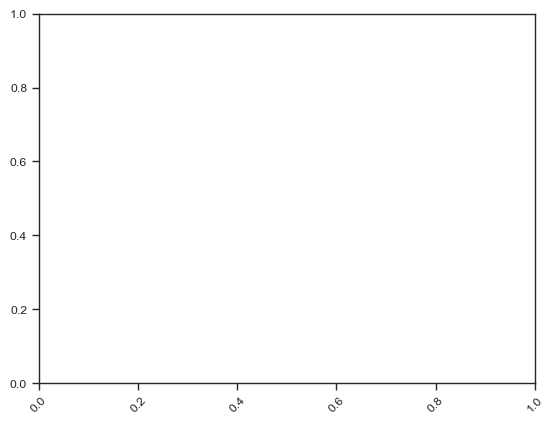

In [94]:
timings = get_inter_event_timings(df, "t1_2", "t1_3", event_disruptor='t2_1', condition='short')
# Plot differences per participant
set_seaborn_style()
sns.barplot(timings, x="participant", y="difference")
plt.xticks(rotation=45)
plt.show()

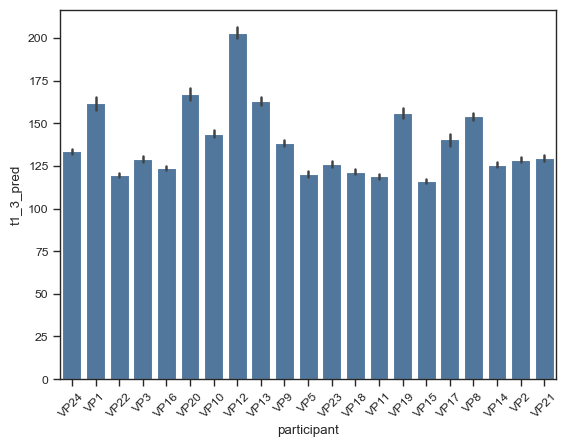

In [53]:
df
set_seaborn_style()
sns.barplot(df, x="participant", y="t1_3_pred")
plt.xticks(rotation=45)
plt.show()

In [63]:
def plot_inter_event_timings(df, event_1, event_2, event_disruptor):
    set_seaborn_style()
    no_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=None, condition='short')
    with_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=event_disruptor, condition='short')
    df = pd.concat([no_disruption, with_disruption])
    sns.boxplot(data=df, x="disrupted", y="difference")
    # plt.xticks([0, 1], ['Not disrupted', f'Disrupted by {event_disruptor}'])
    plt.ylabel(f"Time between {event_1} and {event_2} (samples)")
    # plt.xlabel(f"Time between {event_1} and {event_2} (samples)")
    plt.show()

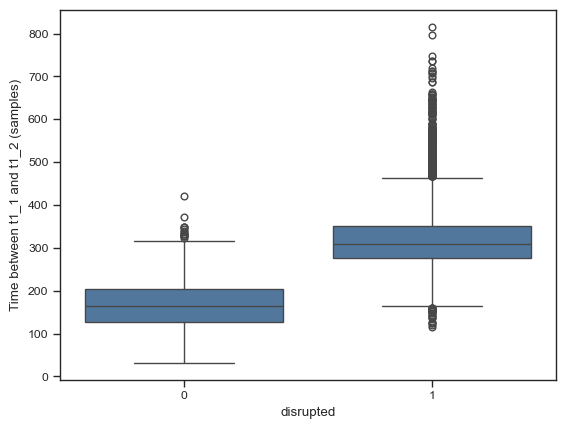

In [64]:
plot_inter_event_timings(df, "t1_1", "t1_2", "t2_1")

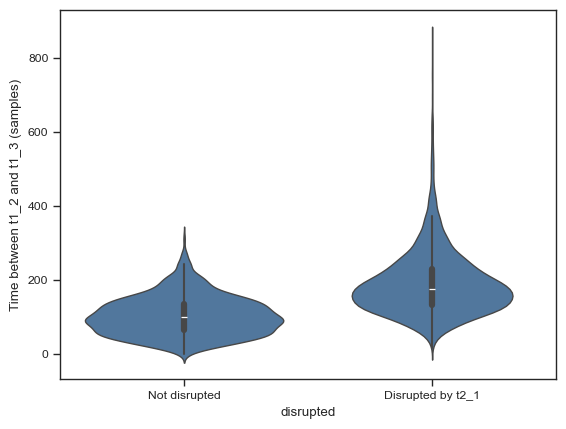

In [338]:
plot_inter_event_timings(df, "t1_2", "t1_3", "t2_1")

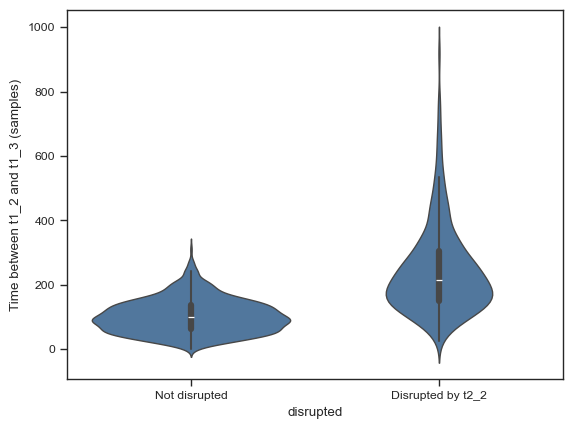

In [339]:
plot_inter_event_timings(df, "t1_2", "t1_3", "t2_2")

In [119]:
def get_disruptor_timings(df, event_1, event_2, event_disruptor, source='long', labels=["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"], source_strategy=(None, None, None)):
    # How long event_1 > event_2 usually takes
    no_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=None, condition=source, source_strategy=source_strategy[0])
    
    # How long event_1 > event_2 takes when event_disruptor is present
    with_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=event_disruptor, condition='short', source_strategy=source_strategy[1])

    # How long event_disruptor > next event usually takes 
    after_disruption = get_inter_event_timings(df, event_disruptor, labels[labels.index(event_disruptor) + 1], condition="short", source_strategy=source_strategy[2])
    # print(f"{event_disruptor} is followed by {labels[labels.index(event_disruptor) + 1]}")
    after_disruption["disrupted"] = 2

    print(f"Found {len(with_disruption)} disruptions (cases where {event_1} > {event_disruptor} > {event_2})")
    df = pd.concat([no_disruption, with_disruption, after_disruption])
    return df

def plot_all_timings():
    results = []
    for event_1, event_2 in [
        ("t1_1", "t1_2"),
        ("t1_2", "t1_3"),
        ("t2_1", "t2_2"),
        ("t2_2", "t2_3"),
        # ("t1_3", "t2_1"),	
    ]:
        for source in ["long", "short"]:
            combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor=None, source=source)
            combination_results["sequence"] = f"{event_1} > {event_2}"
            results.append(combination_results)
    results = pd.concat(results)
    return results

In [ ]:
results = []
for event_1, event_2 in [
    ("t1_1", "t1_2"),
    ("t1_2", "t1_3"),
    ("t2_1", "t2_2"),
    ("t2_2", "t2_3"),
    ("t1_3", "t2_1"),	
]:
    for source in ["long", "short"]:
        combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor=None, source=source)
        combination_results["sequence"] = f"{event_1} > {event_2}"
        results.append(combination_results)
results = pd.concat(results)

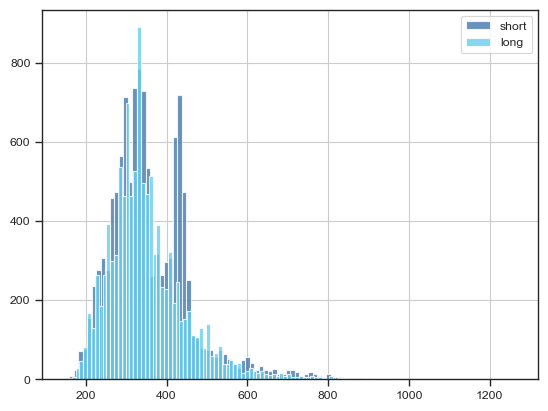

In [92]:
((df[df['condition'] == 'short']['t1_2_pred'] / 250) * 1000).hist(bins=100, alpha=0.8, label='short')
((df[df['condition'] == 'long']['t1_2_pred'] / 250) * 1000).hist(bins=100, alpha=0.8, label='long')
plt.legend()
plt.show()

Disrupted sequences vs non-disrupted sequences, per unique disruption, uses only SHORT timings from default order

Found 5888 disruptions (cases where t1_2 > t2_1 > t1_3)


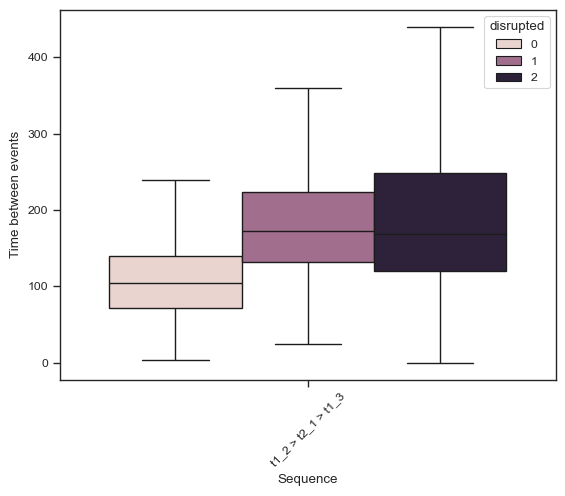

In [121]:
def plot_disruptor_timings(df, event_1, event_2, event_disruptor):
    set_seaborn_style()
    combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor, source="short", source_strategy=[0, 1, 0])
    combination_results["sequence"] = f"{event_1} > {event_disruptor} > {event_2}"
    sns.boxplot(combination_results, x="sequence", y="difference", hue="disrupted", showfliers=False)
    plt.xlabel("Sequence")
    plt.ylabel("Time between events")
    plt.xticks(rotation=45)
    plt.show()

plot_disruptor_timings(df, "t1_2", "t1_3", "t2_1")

t2_1 is followed by t2_2
Found 2005 disruptions (cases where t1_1 > t2_1 > t1_2)


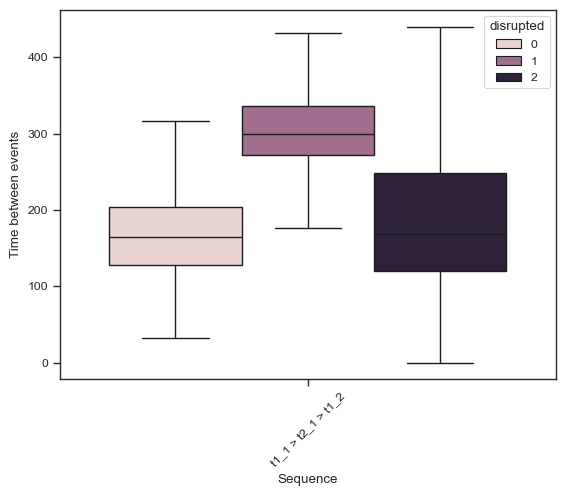

In [114]:
results = []
for event_1, event_2, event_disruptor in [
    ("t1_1", "t1_2", "t2_1"),
    # ("t1_2", "t1_3", "t2_1"),
    # ("t1_2", "t1_3", "t2_2"),
    # ("t2_1", "t2_2", "t1_3"),
    # ("t2_2", "t2_3", "t1_3"),
]:
    combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor, source="short", source_strategy=[0, 2, 0])
    combination_results["sequence"] = f"{event_1} > {event_disruptor} > {event_2}"
    results.append(combination_results)

results = pd.concat(results)
set_seaborn_style()
sns.boxplot(results, x="sequence", y="difference", hue="disrupted", showfliers=False)
plt.xlabel("Sequence")
plt.ylabel("Time between events")
# plt.ylim(0, 500)
plt.xticks(rotation=45)
plt.show()

t2_1 is followed by t2_2
Found 1289 disruptions (cases where t1_1 > t2_1 > t1_2)


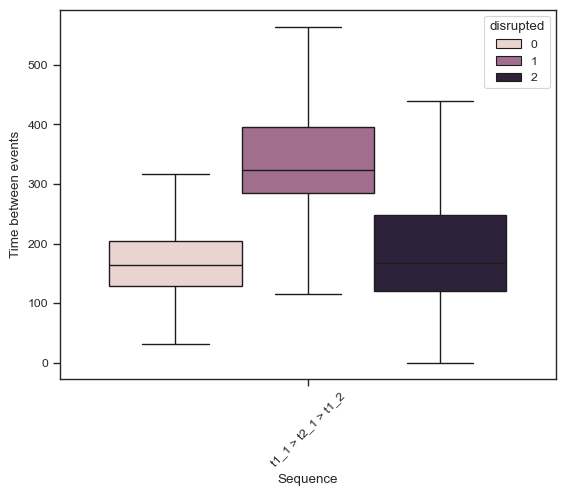

In [115]:
results = []
for event_1, event_2, event_disruptor in [
    ("t1_1", "t1_2", "t2_1"),
    # ("t1_2", "t1_3", "t2_1"),
    # ("t1_2", "t1_3", "t2_2"),
    # ("t2_1", "t2_2", "t1_3"),
    # ("t2_2", "t2_3", "t1_3"),
]:
    combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor, source="short", source_strategy=[0, 4, 0])
    combination_results["sequence"] = f"{event_1} > {event_disruptor} > {event_2}"
    results.append(combination_results)

results = pd.concat(results)
set_seaborn_style()
sns.boxplot(results, x="sequence", y="difference", hue="disrupted", showfliers=False)
plt.xlabel("Sequence")
plt.ylabel("Time between events")
# plt.ylim(0, 500)
plt.xticks(rotation=45)
plt.show()

In [68]:
for sequence in results["sequence"].unique():
    sequence_df = results[results["sequence"] == sequence]
    disr_0 = sequence_df[sequence_df["disrupted"] == 0]["difference"]
    disr_1 = sequence_df[sequence_df["disrupted"] == 1]["difference"]
    disr_2 = sequence_df[sequence_df["disrupted"] == 2]["difference"]

    n_boot = 10000
    boot_diffs = []
    for _ in range(n_boot):
        boot_0 = np.random.choice(disr_0, size=len(disr_0), replace=True).mean()
        boot_1 = np.random.choice(disr_1, size=len(disr_1), replace=True).mean()
        boot_2 = np.random.choice(disr_2, size=len(disr_2), replace=True).mean()
        diff = boot_2 - (boot_1 - boot_0)
        boot_diffs.append(diff)

    lower, upper = np.percentile(boot_diffs, [2.5, 97.5])
    print(f"{sequence} 95% CI: [{lower:.2f}, {upper:.2f}]")
# How much bigger the difference between disruptor > next is than the difference between event 1 > event 2 with and without disruptor

t1_1 > t2_1 > t1_2 95% CI: [26.53, 39.93]


In [ ]:
from contextlib import redirect_stdout
import io, warnings

def model_inter_event_timings(df, event_1, event_2, event_disruptor, source='long'):
    no_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=None, condition=source)
    no_disruption['condition'] = 'long'
    with_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=event_disruptor, condition='short')
    print(f"Found {len(with_disruption)} disruptions (cases where {event_1} > {event_disruptor} > {event_2})")
    df = pd.concat([no_disruption, with_disruption])
    df["disrupted"] = df["condition"] == 'short'
    df["participant"] = df["participant"].astype("category")
    df["condition"] = df["condition"].astype("category")

    formula = "difference ~ disrupted + (1|participant)"
    model = Lmer(formula, data=df)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with redirect_stdout(io.StringIO()):
            model.fit(verbose=False)

    # print(model.summary())
    return model

In [ ]:
def plot_modelled_inter_event_timings():
    results = []
    for event_1, event_2, event_disruptor in [
        ("t1_1", "t1_2", "t2_1"),
        ("t1_2", "t1_3", "t2_1"),
        ("t1_2", "t1_3", "t2_2"),
        ("t2_1", "t2_2", "t1_3"),
        ("t2_2", "t2_3", "t1_3"),
    ]:
        for source in ["long", "short", None]:
            model = model_inter_event_timings(
                df, event_1, event_2, event_disruptor, source=source
            )
            disruptor_effect = model.coefs["Estimate"].iloc[1].item()
            disruptor_effect_SE = model.coefs["SE"].iloc[1].item()
            combination_results = {
                "sequence": " > ".join([event_1, event_disruptor, event_2]),
                "source": source,
                "disruptor_effect": disruptor_effect,
                "disruptor_SE": disruptor_effect_SE,
            }
            results.append(combination_results)

    results = pd.DataFrame(results)
    results["source"] = results["source"].fillna("combined")
    set_seaborn_style()
    sns.lineplot(results, x="source", y="disruptor_effect", hue="sequence")
    plt.title("Inter-Event Timing (IET) disruption")
    plt.ylabel("Effect of disruption (ms) on IET")
    plt.xlabel("Source of valid IET")
    plt.xticks(rotation=45)
    plt.ylim(0, 200)
    plt.show()

In [ ]:
plot_modelled_inter_event_timings()

In [ ]:
# get_inter_event_timings(df, 't1_1', 't1_2', event_disruptor='t2_1', condition='short')['difference'].hist()
sns.violinplot(x=0, y=get_inter_event_timings(df, 't1_2', 't1_3', event_disruptor=None, condition='short')['difference'])
sns.violinplot(x=1, y=get_inter_event_timings(df, 't1_2', 't1_3', event_disruptor=None, condition='long')['difference'])

In [ ]:
model = model_inter_event_timings(df, "t1_1", "t1_2", "t2_1")